In [1]:
import networkx as nx
from rdflib import Graph
import rdflib
from xml.dom import minidom
import os
from openai import OpenAI
import plotly.graph_objects as go
import time
from utils import rdf_to_nx_graph, search_in_rdf_graph, graph_mots_cle, \
    graph_construct, produit_cartesien, ranking
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_hist(ed,precision,recall,f1_score):
    nb_elements = len(ed)

    x = range(nb_elements)

    bar_width = 0.2

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    fig, ax = plt.subplots()

    for i in range(nb_elements):
        ax.bar(x[i] - 1.5 * bar_width, ed[i], width=bar_width, color=colors[0])
        ax.bar(x[i] - 0.5 * bar_width, precision[i], width=bar_width, color=colors[1])
        ax.bar(x[i] + 0.5 * bar_width, recall[i], width=bar_width, color=colors[2])
        ax.bar(x[i] + 1.5 * bar_width, f1_score[i], width=bar_width, color=colors[3])

    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in range(1, nb_elements + 1)])

    ax.legend(['Edit distance', 'Precision', 'Recall', 'F1 Score'])

    plt.xlabel('Requete N°')
    plt.ylabel('Valeurs')
    plt.title('Histogramme des metriques pour chaque requetes')

    plt.show()

In [4]:
def search(keywords, client, rdf_data, ontologie = None):

    rdf_graph = Graph()
    rdf_graph.parse(data=rdf_data.toxml(), format="xml")
    nx_graph = rdf_to_nx_graph(rdf_graph)
    if ontologie is not None:
        ont = ontologie.toxml()
    times = {}
    time_start = time.time()
    selected_elements = search_in_rdf_graph(rdf_graph, keywords, client, rdf_data.toxml(), ontologie=ont)
    time_end = time.time()
    times['etape1'] = time_end - time_start
    time_start = time.time()
    kw_cartesien_sub_graphs = produit_cartesien(selected_elements)
    time_end = time.time()
    times['produit_cartesien'] = time_end - time_start
    best_rank = 0
    optimal_graph = None
    times['graph_construct']= 0
    times['graph_mots_cle']= 0
    times['ranking']= 0
    time_start = time.time()
    for i in range(len(kw_cartesien_sub_graphs)):
        time2_start = time.time()
        pred, nodes = graph_construct(kw_cartesien_sub_graphs[i], nx_graph)
        time2_end = time.time()
        times['graph_construct'] += time2_end - time2_start
        time2_start = time.time()
        graph_etape2 = graph_mots_cle(pred, nodes)
        graph_etape1 = graph_mots_cle(kw_cartesien_sub_graphs[i]['predicates_kw'], kw_cartesien_sub_graphs[i]['nodes_kw'])
        time2_end = time.time()
        times['graph_mots_cle'] += time2_end - time2_start
        time2_start = time.time()
        rank = ranking(graph_etape1, graph_etape2)
        time2_end = time.time()
        times['ranking'] += time2_end - time2_start
        if rank>best_rank:
            best_rank = rank
            optimal_graph = graph_etape2
    time_end = time.time()
    times['choix_meilleur_graph'] = time_end - time_start
    return optimal_graph, times
        

In [5]:
def draw_graph_plotly(G):

    pos = nx.spring_layout(G)

    node_x = [pos[node][0] for node in G.nodes()]
    node_y = [pos[node][1] for node in G.nodes()]
    node_text_brieve = []
    node_text = []
    for i in G.nodes():
        node_text_brieve.append(str(i).split(('/'))[-1])
        node_text.append(str(i))
    edge_text_brieve = [str(edge[2]['type']).split('/')[-1][:10]
                        for edge in G.edges(data=True)]
    edge_text = [str(edge[2]['type']) for edge in G.edges(data=True)]

    # Create edges
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='text',
        mode='lines')

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    # Add edge weights
    edge_trace.text = edge_text_brieve

    # Create middle point coordinates for edge text
    edge_text_trace = go.Scatter(
        x=[(pos[edge[0]][0] + pos[edge[1]][0]) / 2 for edge in G.edges()],
        y=[(pos[edge[0]][1] + pos[edge[1]][1]) / 2 for edge in G.edges()],
        text=edge_trace.text,
        mode='text',
        hoverinfo='text',
        hovertext=edge_text,
        textposition='top center'
    )

    # Create nodes
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=node_text_brieve,
        hovertext=node_text,
        textposition='bottom center',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)
        )
    )

    # Create the figure
    fig = go.Figure(data=[edge_trace, edge_text_trace, node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=0),
                        xaxis=dict(showgrid=False, zeroline=False,
                                   showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False,
                                   showticklabels=False)
                    ))

    # Show the plot
    fig.show()


In [6]:
os.environ['OPENAI_API_KEY'] = ""

client = OpenAI()

# Experimentations sur le temps d'execution

In [ ]:
file_path = "Dataset/data.rdf.xml"
rdf_graph = Graph()

with open(file_path, "r", encoding="utf-8") as rdf_file:
    rdf_data = minidom.parseString(rdf_file.read())

rdf_graph.parse(data=rdf_data.toxml(), format="xml")
nx_graph = rdf_to_nx_graph(rdf_graph)

In [5]:
requetes = []
requetes.append(["josh","starring"])
requetes.append(["Daniel","starring"])
requetes.append(["2005","film","starring","director"])
requetes.append(["name","birthDate","Camp Rock"])
requetes.append(["releaseDate","starring","director","Becoming_Human"])
requetes.append(["title","starring", "Guy"])
requetes.append(["film","starring","2002","name","birthDate"])
requetes.append(["director","film","2002"])

times = []
for req in requetes:
    for i in range(10):
        time_start = time.time()
        graph, time_exec = search(req,client,rdf_data)
        time_end = time.time()
        time_exec['total'] = time_end - time_start
        time_exec['nb_noeuds'] = graph.number_of_nodes()
        times.append(time_exec)

In [6]:
import pandas as pd
import numpy as np

temps_global = [temps['total'] for temps in times]

median_value = np.median(temps_global)
mean_value = np.mean(temps_global)
std_deviation = np.std(temps_global)
min_value = np.min(temps_global)
max_value = np.max(temps_global)

mean_nb_noeuds = np.mean([temps['nb_noeuds'] for temps in times])

stats_df = pd.DataFrame({
    'Statistic': ['Median', 'Mean', 'ecart type', 'Min', 'Max','Mean nb nodes'],
    'Value': [median_value, mean_value, std_deviation, min_value, max_value, mean_nb_noeuds]
})

print(stats_df)

       Statistic     Value
0         Median  0.018002
1           Mean  0.048981
2     ecart type  0.080550
3            Min  0.004999
4            Max  0.390057
5  Mean nb nodes  3.750000


In [7]:
time_etape1 = np.mean([temps['etape1'] for temps in times])
time_produit_cartesien = np.mean([temps['produit_cartesien'] for temps in times])
time_choix_meilleur_graph = np.mean([temps['choix_meilleur_graph'] for temps in times])
time_graph_construct = np.mean([temps['graph_construct'] for temps in times])
time_graph_gen = np.mean([temps['graph_mots_cle'] for temps in times])
time_ranking = np.mean([temps['ranking'] for temps in times])

# Step 2: Create your data
labels = ['etape1','produit_cartesien', 'graph_construction', 'ranking']
values = [time_etape1, time_produit_cartesien, time_graph_construct, time_ranking]

# Step 3: Create a pie chart using Plotly
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

# Step 4: Customize the layout
fig.update_layout(title="Temps passé dans chaque partie de l'algorithme")

# Step 5: Show the plot
fig.show()

In [14]:
k = [[i for i in range(j*10,j*10+10)] for j in range(8)]
def list_exec_time(k,times):
    time_etape1 = np.sum([times[i]['etape1'] for i  in k])
    time_produit_cartesien = np.sum([times[i]['produit_cartesien'] for i  in k])
    time_graph_construct = np.sum([times[i]['graph_construct'] for i  in k])
    time_ranking = np.sum([times[i]['ranking'] for i  in k])
    return [time_etape1, time_produit_cartesien, time_graph_construct, time_ranking]


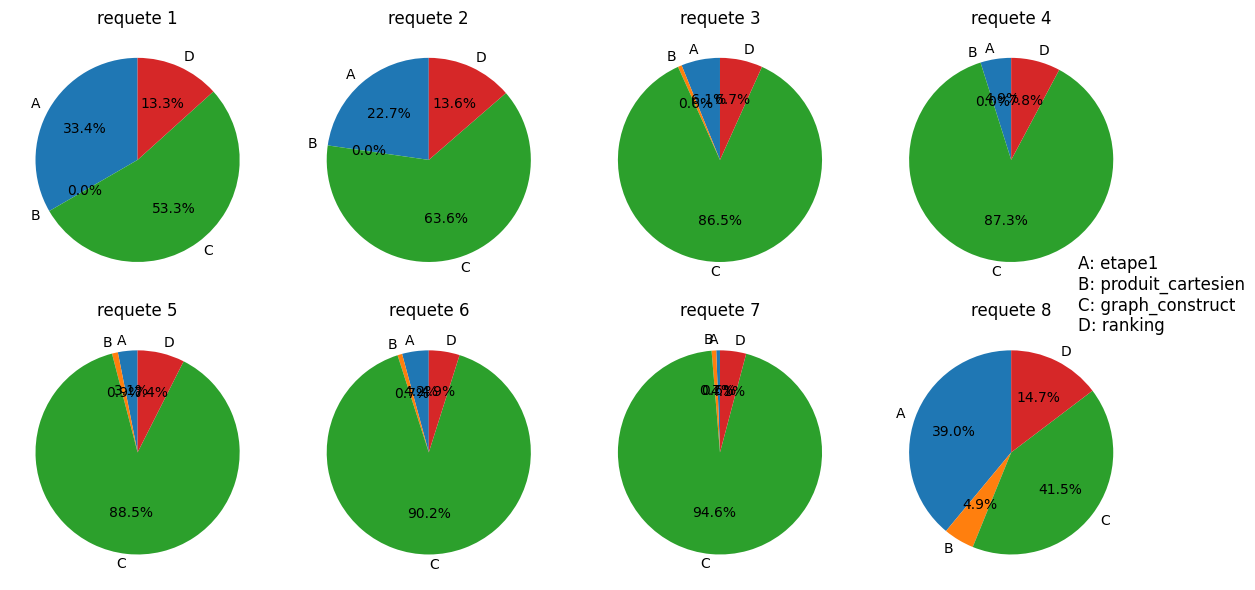

In [20]:
import matplotlib.pyplot as plt

lab = ['A','B', 'C', 'D']
# Create your data for each pie chart
labels = [lab for i in range(8)]
values = [list_exec_time(k[0],times), list_exec_time(k[1],times), list_exec_time(k[2],times), list_exec_time(k[3],times),
          list_exec_time(k[4],times), list_exec_time(k[5],times), list_exec_time(k[6],times), list_exec_time(k[7],times)]

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each pie chart
for i, (label, value) in enumerate(zip(labels, values)):
    axs[i].pie(value, labels=label, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(f'requete {i+1}')
legend_labels = {'A': 'etape1', 'B': 'produit_cartesien', 'C': 'graph_construct', 'D': 'ranking'}

legend_list = [f"{label}: {legend_labels[label]}" for label in legend_labels]

plt.tight_layout()

fig.text(0.92, 0.5, '\n'.join(legend_list), fontsize=12, verticalalignment='center')



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Experimentation sur la qualité des graph résultats

In [5]:
def metrics(G1, G2): 
    #G1 is reference graph 
    edit_distance = nx.graph_edit_distance(G1, G2)
    
    TP = sum(1 for u, v, d in G1.edges(data=True) if G2.has_edge(u, v) and G2[u][v]['type'] == d['type']) + \
     sum(1 for n in G1.nodes() if G2.has_node(n))
    FP = sum(1 for u, v, d in G2.edges(data=True) if not G1.has_edge(u, v) or G1[u][v]['type'] != d['type']) + \
     sum(1 for n in G2.nodes() if not G1.has_node(n))
    FN = sum(1 for u, v, d in G1.edges(data=True) if not G2.has_edge(u, v) or G2[u][v]['type'] != d['type']) + \
     sum(1 for n in G1.nodes() if not G2.has_node(n))

    # recall and precision
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

    return edit_distance, precision, recall, f1_score

## Films dataset

In [ ]:
file_path = "Dataset/data.rdf.xml"

with open(file_path, "r", encoding="utf-8") as rdf_file:
    rdf_data = minidom.parseString(rdf_file.read())

### requetes

In [298]:
requetes = []
requetes.append(["josh brown","starring"])
requetes.append(["film","actor","name","2011"])
requetes.append(['Daniel Fathers','starring','name'])
requetes.append(["2005","film","starring","director"])
requetes.append(["name","birthDate","Camp Rock"])
requetes.append(["releaseDate","starring","director","Ma femme s'appelle Maurice"])
requetes.append(["title","director", "Mark"])
requetes.append(["film","starring","2002","name","birthDate"])
requetes.append(["director","film","2002"])
requetes.append(["film","actor","2008"])


In [333]:
requetes_syn = []
requetes_syn.append(["josh brown","played in"])
requetes_syn.append(["movie","actor","name of actor","2011"])
requetes_syn.append(['Daniel Fathers','acted in','name'])
requetes_syn.append(["2005","film","starring","the person who direct a film"])
requetes_syn.append(["name","date of birth of actor","Camp Rock"])
requetes_syn.append(["date of film","starring","director","Ma femme s'appelle Maurice"])
requetes_syn.append(["title","direc", "Mark"])
requetes_syn.append(["film","the verb of acting","2002","name","birthDate"])
requetes_syn.append(["director","movi","2002"])
requetes_syn.append(["film","actr","2008"])

### graph reponse ideal

In [297]:
graphs_ideal = []
graph1 = graph_mots_cle([{'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Josh_Brown_(actor)'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Becoming_Human'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')}],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/Josh_Brown_(actor)'),rdflib.term.URIRef('http://dbpedia.org/resource/Becoming_Human')
                  ])

graph2 = graph_mots_cle([{'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Becoming_Human'),
                          'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Josh_Brown_(actor)'),
                          'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')},
                          {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Becoming_Human'),
                           'node_dest':rdflib.term.Literal('2011-01-26', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                           'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/releaseDate')},
                           {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Josh_Brown_(actor)'),
                            'node_dest':rdflib.term.Literal('Josh Brown', lang='en'),
                            'predicate':rdflib.term.URIRef('http://dbpedia.org/property/name')}],
                        [rdflib.term.URIRef('http://dbpedia.org/resource/Becoming_Human'),
                         rdflib.term.Literal('Josh Brown', lang='en'),
                         rdflib.term.URIRef('http://dbpedia.org/resource/Josh_Brown_(actor)'),
                         rdflib.term.Literal('2011-01-26', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date'))])

graph3 = graph_mots_cle([{'node_src':rdflib.term.Literal('Daniel Fathers', lang='en'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Daniel_Fathers'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/property/name')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Daniel_Fathers'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Camp_Rock'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/Daniel_Fathers'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Camp_Rock'),
                  rdflib.term.Literal('Daniel Fathers', lang='en')])

graph4 = graph_mots_cle([{'node_src':rdflib.term.Literal('2005-08-27', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Pterodactyl_(film)'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/releaseDate')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pterodactyl_(film)'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Mircea_Monroe'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pterodactyl_(film)'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Mark_L._Lester'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/director')}
                 ],
                 [rdflib.term.Literal('2005-08-27', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Pterodactyl_(film)'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Mircea_Monroe'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Mark_L._Lester')])

graph5 = graph_mots_cle([{'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Daniel_Fathers'),
                 'node_dest':rdflib.term.Literal('1966-03-23', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/birthDate')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Camp_Rock'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Daniel_Fathers'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Daniel_Fathers'),
                 'node_dest':rdflib.term.Literal('Daniel Fathers', lang='en'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/property/name')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/Daniel_Fathers'),
                 rdflib.term.URIRef('http://dbpedia.org/resource/Camp_Rock'),
                 rdflib.term.Literal('1966-03-23', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 rdflib.term.Literal('Daniel Fathers', lang='en')])

graph6 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Régis_Laspalès'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')},
                 {'node_src':rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                 'node_dest':rdflib.term.Literal("http://dbpedia.org/resource/Guy_Marchand"),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')},
                 {'node_src':rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                 'node_dest':rdflib.term.Literal('2002-09-25', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/releaseDate')},
                 {'node_src':rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Jean-Marie_Poiré'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/director')}
                 ],
                 [rdflib.term.Literal('2002-09-25', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 rdflib.term.URIRef('http://dbpedia.org/resource/Régis_Laspalès'),
                 rdflib.term.Literal("http://dbpedia.org/resource/Guy_Marchand"),
                 rdflib.term.URIRef('http://dbpedia.org/resource/Jean-Marie_Poiré'),
                 rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice")])

graph7 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pterodactyl_(film)'),
                  'node_dest':rdflib.term.Literal('Pterodactyl', lang='en'),
                  'predicate':rdflib.term.URIRef('http://dbpedia.org/property/title')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pterodactyl_(film)'),
                  'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Mark_L._Lester'),
                  'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/director')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/Pterodactyl_(film)'),
                 rdflib.term.Literal('Pterodactyl', lang='en'),
                 rdflib.term.URIRef('http://dbpedia.org/resource/Mark_L._Lester'),
                 ])

graph8 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Régis_Laspalès'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')},
                 {'node_src':rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                 'node_dest':rdflib.term.Literal("http://dbpedia.org/resource/Guy_Marchand"),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Régis_Laspalès'),
                 'node_dest':rdflib.term.Literal('1957-02-25', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/birthDate')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Régis_Laspalès'),
                 'node_dest': rdflib.term.Literal('Régis Laspalès', lang='en'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/property/name')},
                 {'node_src':rdflib.term.Literal("http://dbpedia.org/resource/Guy_Marchand"),
                 'node_dest': rdflib.term.Literal('1937-05-22', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/birthDate')},
                 {'node_src':rdflib.term.Literal("http://dbpedia.org/resource/Guy_Marchand"),
                 'node_dest': rdflib.term.Literal('Guy Marchand', lang='en'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/property/name')},
                 {'node_src':rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                 'node_dest':rdflib.term.Literal('2002-09-25', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/releaseDate')}
                 ],
                 [rdflib.term.Literal('2002-09-25', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 rdflib.term.URIRef('http://dbpedia.org/resource/Régis_Laspalès'),
                 rdflib.term.Literal("http://dbpedia.org/resource/Guy_Marchand"),
                 rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                 rdflib.term.Literal('Guy Marchand', lang='en'),
                 rdflib.term.Literal('1937-05-22', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 rdflib.term.Literal('Régis Laspalès', lang='en'),
                 rdflib.term.Literal('1957-02-25', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date'))
                 ])

graph9 = graph_mots_cle([{'node_src':rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                          'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Jean-Marie_Poiré'),
                          'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/director')},
                          {'node_src':rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                           'node_dest':rdflib.term.Literal('2002-09-25', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                           'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/releaseDate')},
                           ],
                        [rdflib.term.URIRef("http://dbpedia.org/resource/Ma_femme_s'appelle_Maurice"),
                         rdflib.term.URIRef('http://dbpedia.org/resource/Jean-Marie_Poiré'),
                         rdflib.term.Literal('2002-09-25', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date'))])

graph10 = graph_mots_cle([{'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Becoming_Human'),
                          'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Josh_Brown_(actor)'),
                          'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/starring')},
                           {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Josh_Brown_(actor)'),
                            'node_dest':rdflib.term.Literal('1990-02-19', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                            'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/birthDate')}],
                        [rdflib.term.URIRef('http://dbpedia.org/resource/Becoming_Human'),
                         rdflib.term.URIRef('http://dbpedia.org/resource/Josh_Brown_(actor)'),
                         rdflib.term.Literal('1990-02-19', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date'))])

graphs_ideal.extend([graph1,graph2,graph3,graph4,graph5,graph6,graph7,graph8,graph9,graph10])

### evaluation requete exacte

In [295]:
graphs_requetes = []
for req in requetes:
    graph, _ = search(req,client,rdf_data)
    graphs_requetes.append(graph)

In [300]:
ed= []
precision = []
recall = []
f1_score = []
for _, (graph_id, graph_req) in enumerate(zip(graphs_ideal,graphs_requetes)) :
    edi, pr, rec, f1=metrics(graph_id,graph_req)
    ed.append(edi)
    precision.append(pr)
    recall.append(rec)
    f1_score.append(f1)

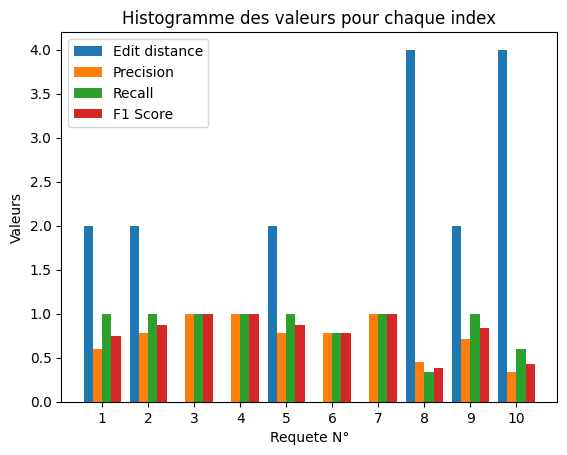

In [325]:
plot_hist(ed,precision,recall,f1_score)

In [320]:

ed_stats = [np.mean(ed), np.std(ed), np.min(ed), np.max(ed)]
precision_stats = [np.mean(precision), np.std(precision), np.min(precision), np.max(precision)]
recall_stats = [np.mean(recall), np.std(recall), np.min(recall), np.max(recall)]
f1_score_stats = [np.mean(f1_score), np.std(f1_score), np.min(f1_score), np.max(f1_score)]

stats_table = np.array([ed_stats, precision_stats, recall_stats, f1_score_stats])

print("Statistiques:")
print("               Moyenne    Ecart-type   Min         Max")
print("Edit distance           :", stats_table[0])
print("Precision    :", stats_table[1])
print("Recall       :", stats_table[2])
print("F1 Score     :", stats_table[3])

Statistiques:
               Moyenne    Ecart-type   Min         Max
ED           : [1.6        1.49666295 0.         4.        ]
Precision    : [0.74354978 0.2177335  0.33333333 1.        ]
Recall       : [0.87111111 0.22084015 0.33333333 1.        ]
F1 Score     : [0.79242979 0.21101787 0.38461538 1.        ]


### evaluation requete necessitant la fonction synonyme

In [334]:
graphs_requetes_syn = []
for req in requetes_syn:
    graph, _ = search(req,client,rdf_data)
    graphs_requetes_syn.append(graph)

In [335]:
ed= []
precision = []
recall = []
f1_score = []
for _, (graph_id, graph_req) in enumerate(zip(graphs_ideal,graphs_requetes_syn)) :
    edi, pr, rec, f1=metrics(graph_id,graph_req)
    ed.append(edi)
    precision.append(pr)
    recall.append(rec)
    f1_score.append(f1)

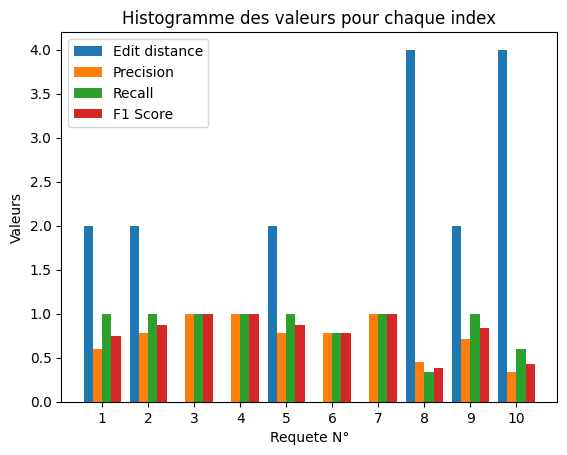

In [336]:
plot_hist(ed,precision,recall,f1_score)

In [337]:
ed_stats = [np.mean(ed), np.std(ed), np.min(ed), np.max(ed)]
precision_stats = [np.mean(precision), np.std(precision), np.min(precision), np.max(precision)]
recall_stats = [np.mean(recall), np.std(recall), np.min(recall), np.max(recall)]
f1_score_stats = [np.mean(f1_score), np.std(f1_score), np.min(f1_score), np.max(f1_score)]

stats_table = np.array([ed_stats, precision_stats, recall_stats, f1_score_stats])

# Affichage du tableau
print("Statistiques:")
print("               Moyenne    Ecart-type   Min         Max")
print("Edit distance:", stats_table[0])
print("Precision    :", stats_table[1])
print("Recall       :", stats_table[2])
print("F1 Score     :", stats_table[3])

Statistiques:
               Moyenne    Ecart-type   Min         Max
Edit distance: [1.6        1.49666295 0.         4.        ]
Precision    : [0.74354978 0.2177335  0.33333333 1.        ]
Recall       : [0.87111111 0.22084015 0.33333333 1.        ]
F1 Score     : [0.79242979 0.21101787 0.38461538 1.        ]


## Livres dataset avec ontologie

In [7]:
file_path = "Dataset/livres.rdf.xml"

with open(file_path, "r", encoding="utf-8") as rdf_file:
    rdf_data = minidom.parseString(rdf_file.read())

file_path_ontology = "Dataset/livres_ontologie.owl.xml"

with open(file_path_ontology, "r", encoding="utf-8") as rdf_file:
    rdf_ontologie = minidom.parseString(rdf_file.read())


### requetes

In [16]:
requetes = []
requetes.append(["game_of_thrones","author","name","publisher"])
requetes.append(["authorname","dateofbirth","harry potter"])
requetes.append(['title','author','publisher','1997'])
requetes.append(["publishername","the lord of the ring"])
requetes.append(['writer','dateofbirth','1892'])
requetes.append(['jane austen','title','publishername'])
requetes.append(['publishername','harry potter'])
requetes.append(['J. K. Rowling','dateofbirth'])
requetes.append(['title','publishername','authorname','dateofbirth','1775'])
requetes.append(['George allen','title'])

In [9]:
requetes_syn = []
requetes_syn.append(["game_of_thrones","Composer","name","Imprint"])
requetes_syn.append(["name of author","birth date of author","harry potter"])
requetes_syn.append(['Heading','author','publisher','1997'])
requetes_syn.append(["Firm","the lord of the ring"])
requetes_syn.append(['Scribe','datbirth','1892'])
requetes_syn.append(['jane austen','Caption','publishername'])
requetes_syn.append(['Publishing company','harry potter'])
requetes_syn.append(['J. K. Rowling','birth'])
requetes_syn.append(['title','Publishing House','authorname','dateofbirth','1775'])
requetes_syn.append(['George allen','Label'])

### Graph des reponses ideal

In [10]:
graphs_ideal = []

graph1 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Game_of_Thrones'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/George_R._R._Martin'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/author')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Game_of_Thrones'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Bantam_Books'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/publisher')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/George_R._R._Martin'),
                 'node_dest':rdflib.term.Literal('George R. R. Martin'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Authorname')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/Game_of_Thrones'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/George_R._R._Martin'),
                  rdflib.term.Literal('George R. R. Martin'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Bantam_Books')])

graph2 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/J._K._Rowling'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/author')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/J._K._Rowling'),
                 'node_dest':rdflib.term.Literal('1965-07-31', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/dateofbirth')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/J._K._Rowling'),
                 'node_dest':rdflib.term.Literal('J. K. Rowling'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Authorname')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/J._K._Rowling'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                  rdflib.term.Literal('1965-07-31', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                  rdflib.term.Literal('J. K. Rowling')])

graph3 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/J._K._Rowling'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/author')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Bloomsbury_Publishing'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/publisher')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                 'node_dest':rdflib.term.Literal("Harry Potter and the Philosopher's Stone"),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/title')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                 'node_dest':rdflib.term.Literal('1997-06-26', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/publishingDate')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/J._K._Rowling'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Bloomsbury_Publishing'),
                  rdflib.term.Literal("Harry Potter and the Philosopher's Stone"),
                  rdflib.term.Literal('1997-06-26', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date'))])

graph4 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/George_Allen_and_Unwin'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/publisher')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/George_Allen_and_Unwin'),
                 'node_dest':rdflib.term.Literal('George Allen and Unwin'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/publisherName')},
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/George_Allen_and_Unwin'),
                  rdflib.term.Literal('George Allen and Unwin'),
                  ])

graph5 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/J._R._R._Tolkien'),
                 'node_dest':rdflib.term.Literal('1892-01-03', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/dateofbirth')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/J._R._R._Tolkien'),
                 'node_dest':rdflib.term.Literal('J. R. R. Tolkien'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Authorname')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/J._R._R._Tolkien'),
                  rdflib.term.Literal('1892-01-03', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                  rdflib.term.Literal('J. R. R. Tolkien')])

graph6 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pride_'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Jane_Austen'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/author')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pride_'),
                 'node_dest':rdflib.term.Literal('Pride and Prejudice'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/title')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pride_'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Thomas_Egerton_(publisher)'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/publisher')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Thomas_Egerton_(publisher)'),
                 'node_dest':rdflib.term.Literal('Thomas Egerton (publisher)'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/publisherName')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Jane_Austen'),
                 'node_dest':rdflib.term.Literal('Jane Austen'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Authorname')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/Jane_Austen'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Pride_'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Thomas_Egerton_(publisher)'),
                  rdflib.term.Literal('Thomas Egerton (publisher)'),
                  rdflib.term.Literal('Pride and Prejudice'),
                  rdflib.term.Literal('Jane Austen')])

graph7 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Bloomsbury_Publishing'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/publisher')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                 'node_dest':rdflib.term.Literal("Harry Potter and the Philosopher's Stone"),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/title')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Bloomsbury_Publishing'),
                 'node_dest':rdflib.term.Literal('Bloomsbury Publishing'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/publisherName')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/Harry_Potter_'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Bloomsbury_Publishing'),
                  rdflib.term.Literal('Bloomsbury Publishing'),
                  rdflib.term.Literal("Harry Potter and the Philosopher's Stone")])

graph8 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/J._K._Rowling'),
                 'node_dest':rdflib.term.Literal('1965-07-31', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/dateofbirth')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/J._K._Rowling'),
                  rdflib.term.Literal('1965-07-31', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                  ])

graph9 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pride_'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Jane_Austen'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/author')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pride_'),
                 'node_dest':rdflib.term.Literal('Pride and Prejudice'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/title')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Pride_'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/Thomas_Egerton_(publisher)'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/publisher')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Thomas_Egerton_(publisher)'),
                 'node_dest':rdflib.term.Literal('Thomas Egerton (publisher)'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/publisherName')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Jane_Austen'),
                 'node_dest':rdflib.term.Literal('Jane Austen'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Authorname')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/Jane_Austen'),
                 'node_dest':rdflib.term.Literal('1775-12-16', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date')),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/dateofbirth')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/Jane_Austen'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Pride_'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/Thomas_Egerton_(publisher)'),
                  rdflib.term.Literal('Thomas Egerton (publisher)'),
                  rdflib.term.Literal('Pride and Prejudice'),
                  rdflib.term.Literal('Jane Austen'),
                  rdflib.term.Literal('1775-12-16', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#date'))])

graph10 = graph_mots_cle([
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/George_Allen_and_Unwin'),
                 'node_dest':rdflib.term.Literal('George Allen and Unwin'),
                 'predicate':rdflib.term.URIRef('http://xmlns.com/foaf/0.1/publisherName')},
                 {'node_src':rdflib.term.URIRef('http://dbpedia.org/resource/The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring'),
                 'node_dest':rdflib.term.URIRef('http://dbpedia.org/resource/George_Allen_and_Unwin'),
                 'predicate':rdflib.term.URIRef('http://dbpedia.org/ontology/publisher')}
                 ],
                 [rdflib.term.URIRef('http://dbpedia.org/resource/The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring'),
                  rdflib.term.URIRef('http://dbpedia.org/resource/George_Allen_and_Unwin'),
                  rdflib.term.Literal('George Allen and Unwin')
                  ])
graphs_ideal.extend([graph1,graph2,graph3,graph4,graph5,graph6,graph7,graph8,graph9,graph10])

### evaluation requete exacte

In [119]:
graphs_requetes = []
for req in requetes:
    graph, _ = search(req,client,rdf_data)
    graphs_requetes.append(graph)

In [120]:
ed= []
precision = []
recall = []
f1_score = []
for _, (graph_id, graph_req) in enumerate(zip(graphs_ideal,graphs_requetes)) :
    edi, pr, rec, f1=metrics(graph_id,graph_req)
    ed.append(edi)
    precision.append(pr)
    recall.append(rec)
    f1_score.append(f1)

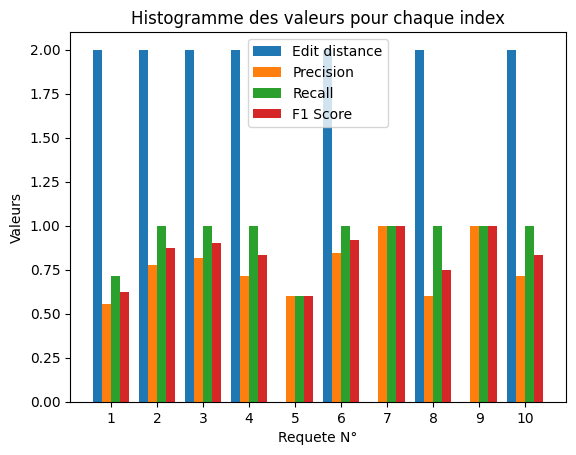

In [121]:
plot_hist(ed,precision,recall,f1_score)

In [123]:
ed_stats = [np.mean(ed), np.std(ed), np.min(ed), np.max(ed)]
precision_stats = [np.mean(precision), np.std(precision), np.min(precision), np.max(precision)]
recall_stats = [np.mean(recall), np.std(recall), np.min(recall), np.max(recall)]
f1_score_stats = [np.mean(f1_score), np.std(f1_score), np.min(f1_score), np.max(f1_score)]

stats_table = np.array([ed_stats, precision_stats, recall_stats, f1_score_stats])

print("Statistiques:")
print("               Moyenne    Ecart-type   Min         Max")
print("Edit distance:", stats_table[0])
print("Precision    :", stats_table[1])
print("Recall       :", stats_table[2])
print("F1 Score     :", stats_table[3])

Statistiques:
               Moyenne    Ecart-type   Min         Max
Edit distance: [1.4        0.91651514 0.         2.        ]
Precision    : [0.76262404 0.14947639 0.55555556 1.        ]
Recall       : [0.93142857 0.13950349 0.6        1.        ]
F1 Score     : [0.83333333 0.13170885 0.6        1.        ]


### evaluation requete necessitant la fonction synonyme

In [11]:
graphs_requetes_syn = []
for req in requetes_syn:
    graph, _ = search(req,client,rdf_data,ontologie=rdf_ontologie)
    graphs_requetes_syn.append(graph)

In [12]:
ed= []
precision = []
recall = []
f1_score = []
for _, (graph_id, graph_req) in enumerate(zip(graphs_ideal,graphs_requetes_syn)) :
    edi, pr, rec, f1=metrics(graph_id,graph_req)
    ed.append(edi)
    precision.append(pr)
    recall.append(rec)
    f1_score.append(f1)

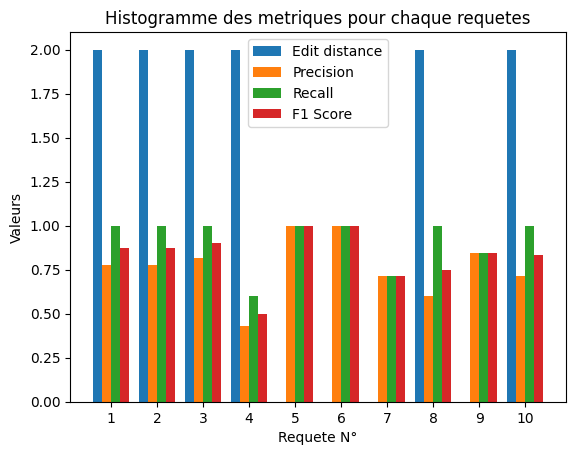

In [13]:
plot_hist(ed,precision,recall,f1_score)

In [14]:
ed_stats = [np.mean(ed), np.std(ed), np.min(ed), np.max(ed)]
precision_stats = [np.mean(precision), np.std(precision), np.min(precision), np.max(precision)]
recall_stats = [np.mean(recall), np.std(recall), np.min(recall), np.max(recall)]
f1_score_stats = [np.mean(f1_score), np.std(f1_score), np.min(f1_score), np.max(f1_score)]

stats_table = np.array([ed_stats, precision_stats, recall_stats, f1_score_stats])

print("Statistiques:")
print("               Moyenne    Ecart-type   Min         Max")
print("Edit distance:", stats_table[0])
print("Precision    :", stats_table[1])
print("Recall       :", stats_table[2])
print("F1 Score     :", stats_table[3])

Statistiques:
               Moyenne    Ecart-type   Min         Max
Edit distance: [1.2       0.9797959 0.        2.       ]
Precision    : [0.76770341 0.1629941  0.42857143 1.        ]
Recall       : [0.91604396 0.13957619 0.6        1.        ]
F1 Score     : [0.82937729 0.13989567 0.5        1.        ]
